# Playing with Lending Club's Loan Data

In this kernel I will be going over the Lending Club Loan Data. The data has a lot of features, some are useful and some are not, some features have a lot of missing values too. I will try to clean this data and make it ready for a great predictive model. <br>
Data Available at: https://www.kaggle.com/wendykan/lending-club-loan-data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Any results you write to the current directory are saved as output.

In [2]:
loans = pd.read_csv("loan.csv", low_memory=False) #Dataset

In [3]:
# Checking the Dimensions of our dataset

loans.shape

(887379, 74)

In [4]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

Now we need to familiarize ourselves with this dataset, and we should understand what these columns represent.

In [43]:
description = pd.read_excel('LCDataDictionary.xlsx').dropna()
description.style.set_properties(subset=['Description'], **{'width' :'850px'})

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


In [ ]:
loans.info()

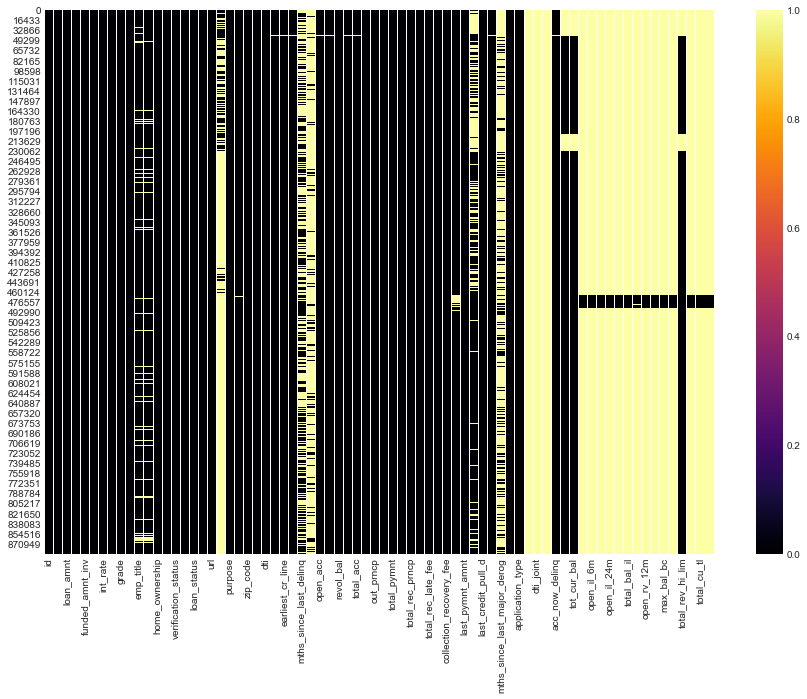

In [6]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(loans.isna(),cmap='inferno')

It is evident from the above heatmap that our dataset contains a lot of missing values and we can not use feature that has so many missing values.

Another thing we would want to examine is that how many loans have a default loan status in comparison to other loans. A common thing to predict in datasets like these are if a new loan will get default or not. I'll be keeping loans with default status as my target variable.

In [7]:
loans['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [65]:
target = [1 if i=='Default' else 0 for i in loans['loan_status']]
loans['target'] = target
loans['target'].value_counts()

0    886160
1      1219
Name: target, dtype: int64

In [9]:
nulls = pd.DataFrame(round(loans.isnull().sum()/len(loans.index)*100,2),columns=['null_percent'])
#sns.barplot(x='index',y='null_percent',data=nulls.reset_index())
nulls[nulls['null_percent']!=0.00].sort_values('null_percent',ascending=False)

,null_percent
annual_inc_joint,99.94
verification_status_joint,99.94
dti_joint,99.94
il_util,97.90
mths_since_rcnt_il,97.65
inq_last_12m,97.59
open_il_24m,97.59
open_il_12m,97.59
open_il_6m,97.59
open_acc_6m,97.59


There are several columns that fit into one of the following categories:

Unneccesary data such as the URL to view the loan <br>
Redundant data. Loan description may be useful to some, but loan purpose fits our needs <br>
User provided information. Employer titles may offer some insight into employment industry, but would need significant cleanup to provide useful statistics <br>
Operational data. The next payment date for the loan at the time the data was generated is not relevant to us 

In [66]:
# Drop unneccesary columns
loans = loans.drop(['url', 'desc', 'policy_code', 'last_pymnt_d', 'next_pymnt_d', 'earliest_cr_line', 'emp_title'], axis=1)
loans = loans.drop(['id', 'title', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'zip_code'], axis=1)


In [67]:
loans['member_id'].value_counts().head(5)

58732538    1
353782      1
56268296    1
59631955    1
73070084    1
Name: member_id, dtype: int64

Since no customer has taken loan again, we can drop member id too.

In [68]:
loans.drop(['member_id'], axis=1, inplace=True)

Additionally, we identified some rows that we decided were not relevant to our needs. The 'loan_status' column is the source of our answer to the core question if people are paying the loans they take out. We found some records with a loan_status of  "Does not meet the credit policy". We believe these may be older loans that would simply not be accepted under LendingClubs current criteria. As these data points will provide no value moving forward, we've ecluded them from our data. Similiarily, recently issued loans could mislead our analysis, as no payment has been expected yet.

In [69]:
i = len(loans)
loans = pd.DataFrame(loans[loans['loan_status'] != "Does not meet the credit policy. Status:Fully Paid"])
loans = pd.DataFrame(loans[loans['loan_status'] != "Does not meet the credit policy. Status:Charged Off"])
loans = pd.DataFrame(loans[loans['loan_status'] != "Issued"])
loans = pd.DataFrame(loans[loans['loan_status'] != "In Grace Period"])
a = len(loans)
print(f"We dropped {i-a} rows, a {((i-a)/((a+i)/2))*100}% reduction in rows")

We dropped 17462 rows, a 1.987371507133687% reduction in rows


# Exploratory Data Analysis

Now I would like to know the distribution of Data types

Text(0.5,0,'Data type')

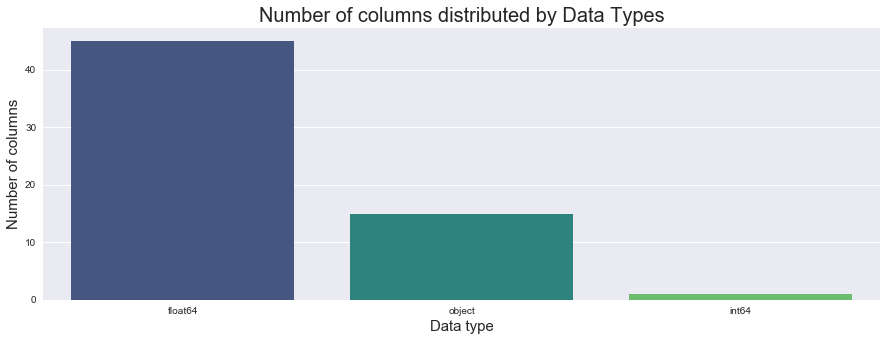

In [14]:
# Number of each type of column
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(loans.dtypes,palette='viridis')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.ylabel('Number of columns',fontsize=15)
plt.xlabel('Data type',fontsize=15)

In [15]:
# Let us see how many Object type features are actually Categorical
loans.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                           2
grade                          7
sub_grade                     35
emp_length                    11
home_ownership                 6
verification_status            3
issue_d                      103
loan_status                    6
pymnt_plan                     2
purpose                       14
addr_state                    51
initial_list_status            2
last_credit_pull_d           102
application_type               2
verification_status_joint      3
dtype: int64

We should have a look at the distribution of Employement Lengths too

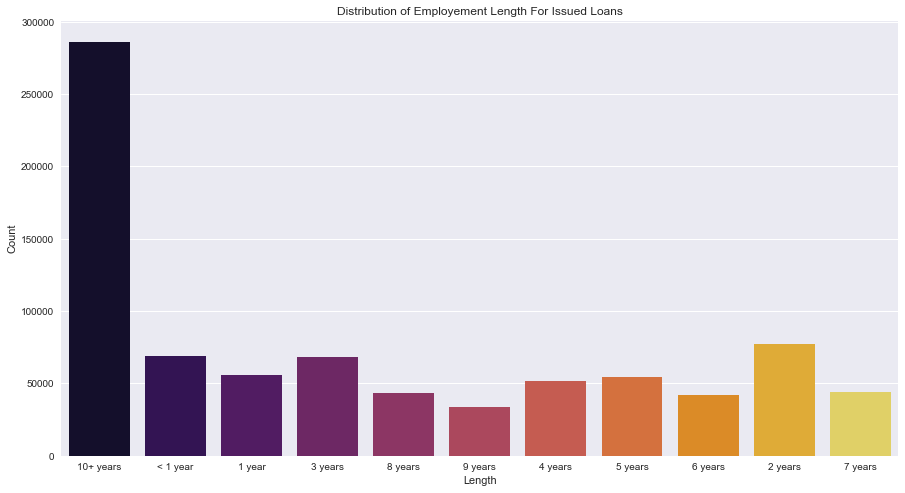

In [16]:
sns.set(rc={'figure.figsize':(15,8)})
sns.countplot(loans['emp_length'],palette='inferno')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employement Length For Issued Loans")
plt.show()

Well, it can be seen that people who have worked for 10 or more years are more likely to take loans

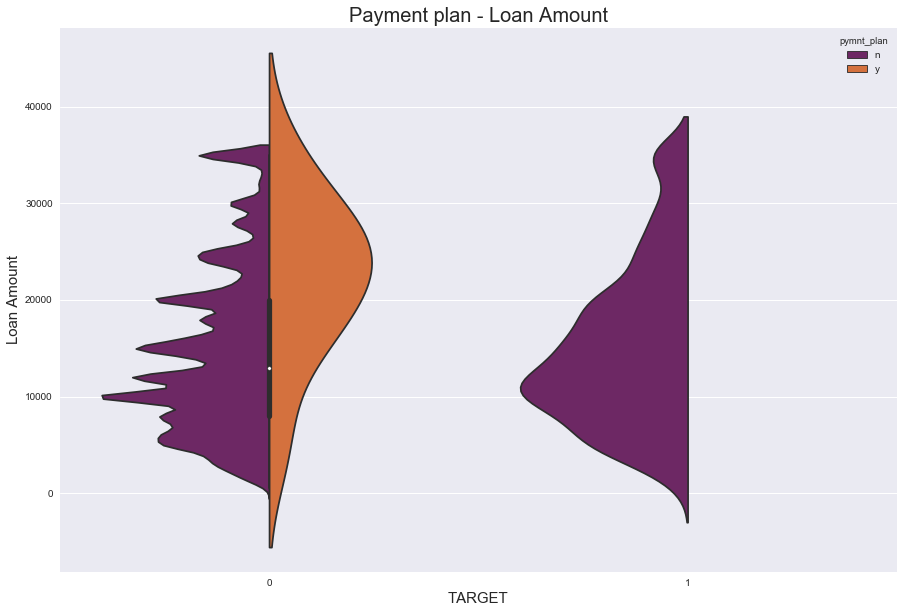

In [17]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="target",y="loan_amnt",data=loans, hue="pymnt_plan", split=True,palette='inferno')
plt.title("Payment plan - Loan Amount", fontsize=20)
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

As expected, people who have defaulted their loans had no payment plan

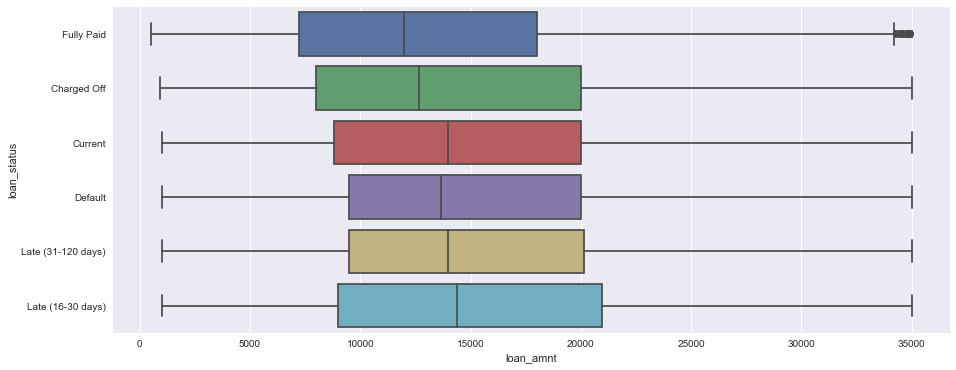

In [18]:
sns.set(rc={'figure.figsize':(15,6)})
sns.boxplot(x='loan_amnt', y='loan_status', data=loans)

Now I would like to know what kind of loans Lending Club usually issues?
I guess this can be answered by having look at Loan Grade that Lending Club assigns.

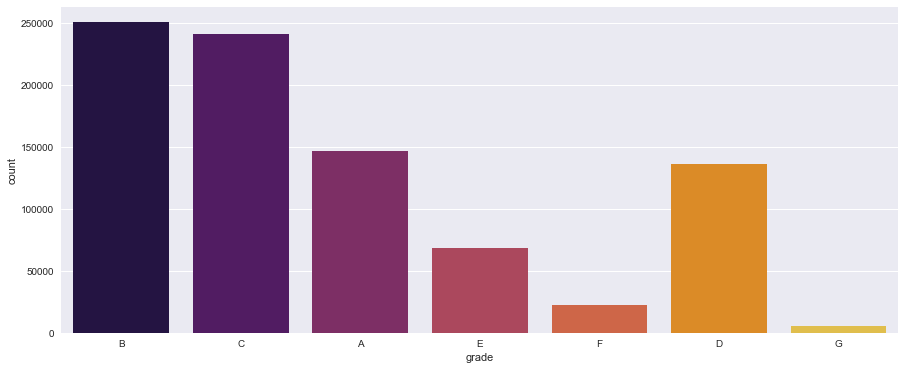

In [19]:
sns.set(rc={'figure.figsize':(15,6)})
sns.countplot(loans['grade'], palette='inferno')

Since most of the loans are of B Grade, we should have a look at their loan amounts too

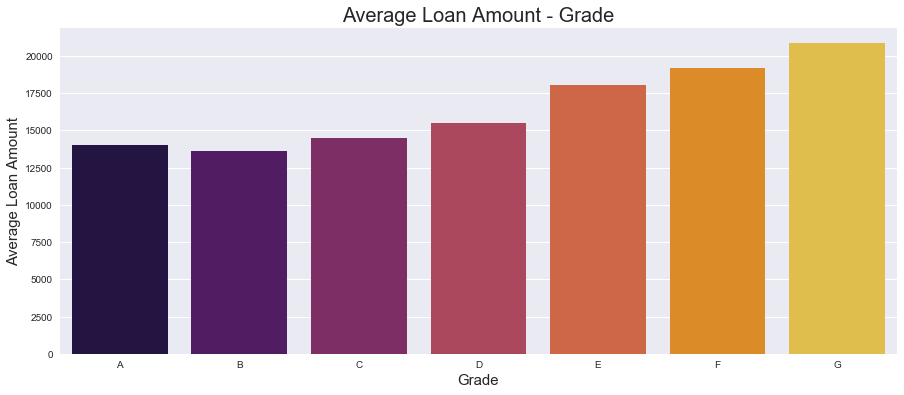

In [20]:
loan_grades = loans.groupby("grade").mean().reset_index()

sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x='grade', y='loan_amnt', data=loan_grades, palette='inferno')
plt.title("Average Loan Amount - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Average Loan Amount", fontsize=15);

Average loan amount of B grade loans is the least of all grades. I guess the higher the grade, lower the loan amount is issued

We should have a look at the interest rates offered for these loan grades.

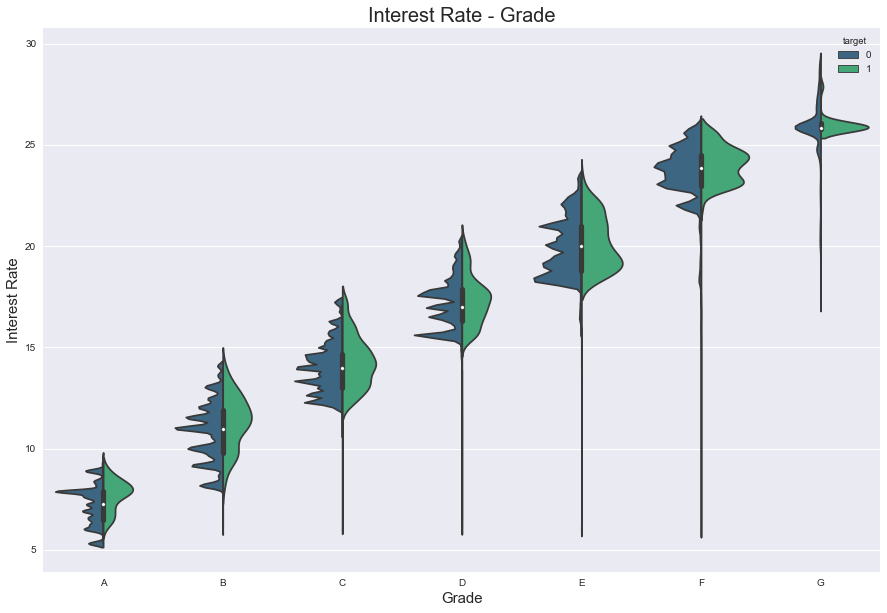

In [21]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="grade", y="int_rate", data=loans, palette='viridis', order="ABCDEFG",hue='target',split=True)
plt.title("Interest Rate - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest Rate", fontsize=15);

I think my previous assumption was right. The higher the loan amount, higher the interest rate.

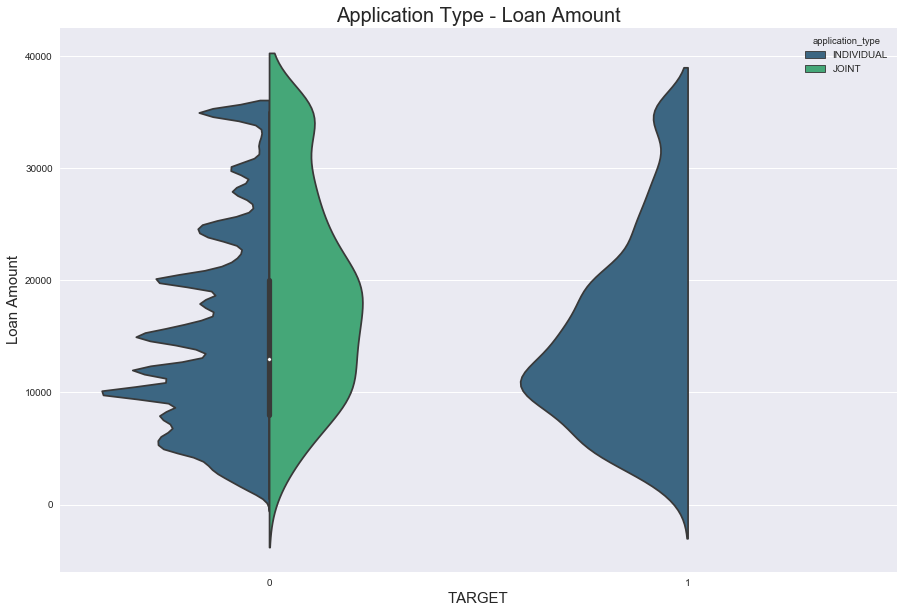

In [22]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="target",y="loan_amnt",data=loans, hue="application_type", split=True,palette='viridis')
plt.title("Application Type - Loan Amount", fontsize=20)
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

So most of the defaulted loans were issued to individuals. Two or more people who take loans have lower chances of defaulting

Let us see the overall distribution of interest rates now.

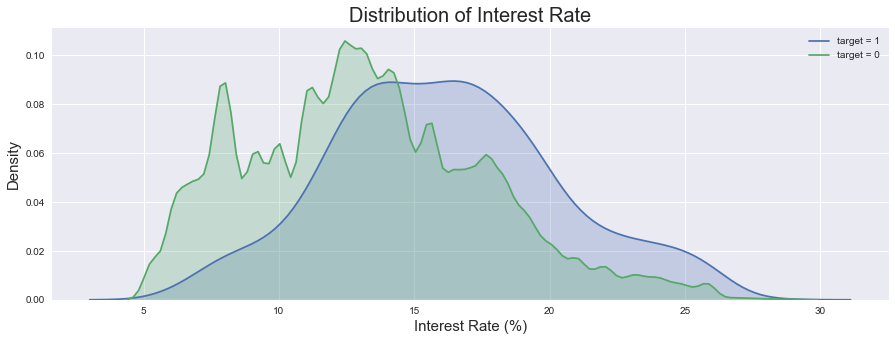

In [23]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(loans.loc[loans['target'] == 1, 'int_rate'], label = 'target = 1',shade=True)
sns.kdeplot(loans.loc[loans['target'] == 0, 'int_rate'], label = 'target = 0',shade=True);
plt.xlabel('Interest Rate (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Interest Rate',fontsize=20);

To which state most of the defaulted loan cases belong?

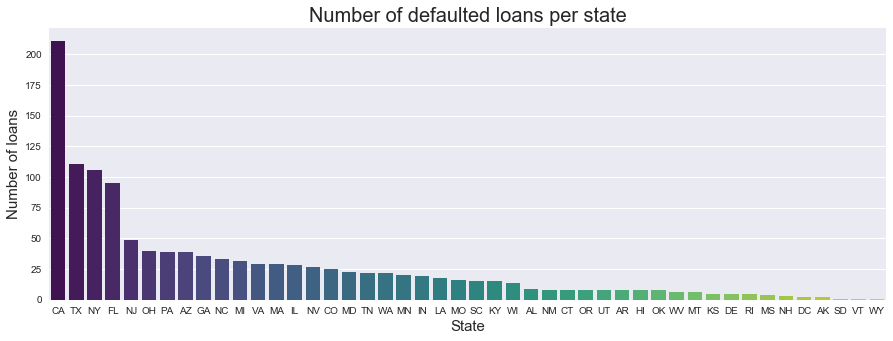

In [24]:
state_default = loans[loans['target']==1]['addr_state']

sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(state_default, order=state_default.value_counts().index, palette='viridis')
plt.xlabel('State',fontsize=15)
plt.ylabel('Number of loans',fontsize=15)
plt.title('Number of defaulted loans per state',fontsize=20);

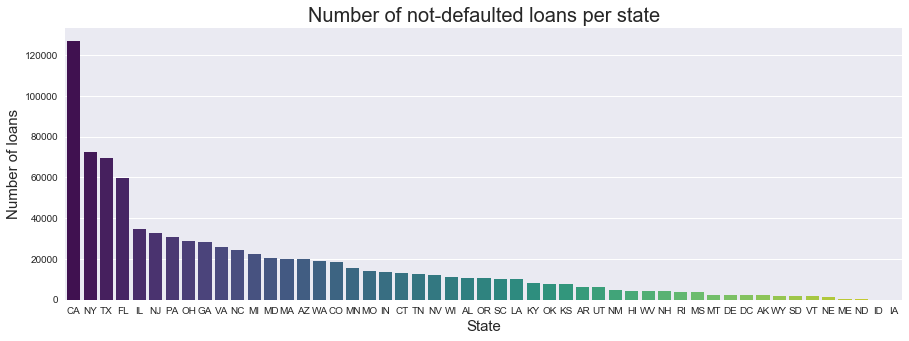

In [25]:
state_non_default = loans[loans['target']==0]['addr_state']

sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(state_non_default, order=state_non_default.value_counts().index, palette='viridis')
plt.xlabel('State',fontsize=15)
plt.ylabel('Number of loans',fontsize=15)
plt.title('Number of not-defaulted loans per state',fontsize=20);

### Summary <br> <br>
Since most of the customers have been employed for 10+ years, the **majority of Lending Club's customers are 30+ years of age**.  <br>
Interest rate varies wildly, reaching **nearly 30%** for high-risk loans <br>
Grade A has the **lowest interest rate** around 7% <br>
Grade G has the **highest interest rate** above 25% <br>
The **lower the grade, the higher loan amount** loan issued <br>
Fully Paid loans tend to be smaller. This could be due to the age of the loans <br>
Default has the highest count among other loan status. <br>
**In Grace Period** and **Late(16~30 days)** have the highest loan amount and mean. <br>
Most of the loans have interest rates between **12% and 18%** <br>
All the loans that have been defaulted are from **individuals** rather than from two or more people. <br>
**California** has the most defaulted and non-defaulted loans out of all the states in US <br>
**States** are not a distinguishing feature for predicting the defaulted loans.

# Cleaning The Data

In [26]:
loans.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'application_type', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_b

As I mentioned earlier, there are some columns/features that are not required. We have already dropped those features.

In [27]:
loans.shape

(869917, 61)

In [29]:
loans.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,target
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Now I am going to drop columns that have more than 75% null values

In [70]:
nulls = pd.DataFrame(round(loans.isnull().sum()/len(loans.index)*100,2),columns=['null_percent'])
drop_cols = nulls[nulls['null_percent']>75.0].index
loans.drop(drop_cols, axis=1, inplace=True)

In [31]:
loans.shape

(869917, 42)

In [32]:
loans.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,0.00,171.62,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,1.11,119.66,Sep-2013,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,0.00,649.91,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,0.00,357.48,Jan-2015,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,0.00,67.79,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0


In [33]:
loans.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
       'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'target'],
      dtype='object')

Now we should convert date object columns to integer years or months so that we can easily encode other categorical features without exhausting our resources. For filling the dates, I am gonna use the most used dates in that feature

In [71]:
loans['issue_d']= pd.to_datetime(loans['issue_d']).apply(lambda x: int(x.strftime('%Y')))
loans['last_credit_pull_d']= pd.to_datetime(loans['last_credit_pull_d'].fillna("2016-01-01")).apply(lambda x: int(x.strftime('%m')))

In [72]:
loans.drop(['loan_status'],axis=1,inplace=True)

In [73]:
categorical = []
for column in loans:
    if loans[column].dtype == 'object':
        categorical.append(column)
categorical

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [75]:
loans = pd.get_dummies(loans, columns=categorical)

In [76]:
loans.shape

(869917, 165)

In [104]:
loans['mths_since_last_delinq'].fillna(loans['mths_since_last_delinq'].median(), inplace=True)

In [105]:
# Finally we are going to drop all the rows that contain null values
loans.dropna(inplace=True)

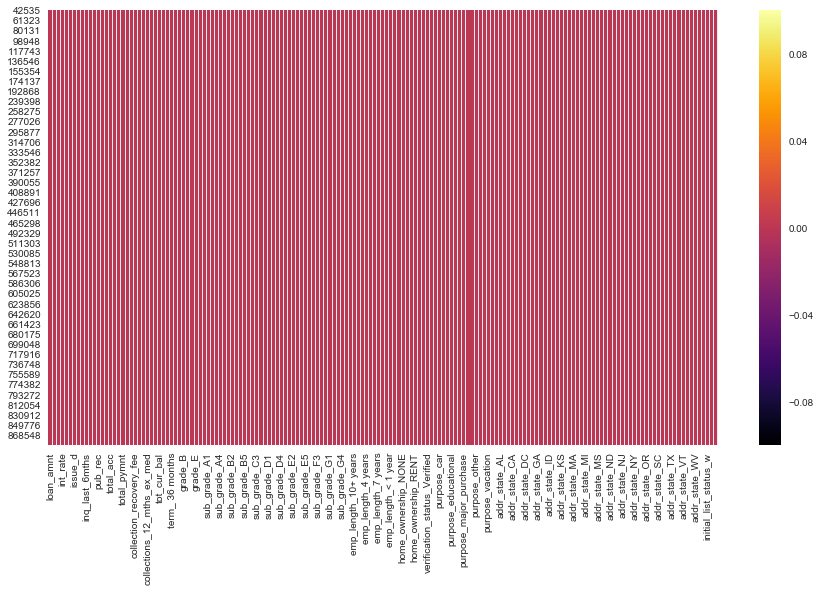

In [42]:
sns.set(rc={'figure.figsize':(15,8)})
sns.heatmap(loans.isna(),cmap='inferno')